In [1]:
%%capture

!pip install /kaggle/input/torch-geometric/torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl
!pip install /kaggle/input/torch-geometric/torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl
!pip install torch-geometric
!pip install ogb

In [2]:
import os
import pandas as pd
import numpy as np

import torch
print("PyTorch has version {}".format(torch.__version__))
import torch.nn.functional as F

PyTorch has version 2.4.0


In [3]:
from torch_geometric.nn import TransformerConv

/opt/conda/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /opt/conda/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/opt/conda/lib/python3.10/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /opt/conda/lib/python3.10/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


## Dataset and Visualization

The dataset under consideration is the "ogbn-arxiv" from the Open Graph Benchmark (OGB). This dataset embodies a citation network, mapped as a directed and heterogeneous graph, that captures the inter-relationships between Computer Science (CS) arXiv papers indexed by the Microsoft Academic Graph (MAG). The dataset encompasses:

- Nodes: Representing arXiv papers, where each node is identified with a unique subject area, culminating in 40 distinct subject categories. There are a total of 169,343 nodes, split into training (90,941), validation (29,799), and testing (48,603) sets based on the publication dates. Specifically, papers published up until 2017 are in the training set, those from 2018 are in the validation set, and those from 2019 onwards form the test set.
- Edges: Representing citation relationships. In this dataset, a directed edge from node A to node B signifies that paper A cites paper B. The dataset contains a total of 1,166,243 such directed edges.
- Node Features: Each paper (node) is equipped with a 128-dimensional feature vector. This feature vector is derived by averaging the embeddings of the words found in the paper's title and abstract. The word embeddings themselves are generated using the skip-gram model applied to the MAG corpus.

First, load and preprocess a graph dataset using the PyTorch Geometric library.

Then, print the dataset's properties, such as the number of nodes, features, and the adjacency matrix's non-zero elements (nnz). It also confirms the device being used (CUDA/GPU in this case).



In [4]:
# Import Libraries
import torch_geometric.transforms as T # Provides transformation utilities for graph data in PyG
from ogb.nodeproppred import PygNodePropPredDataset # load node property prediction datasets from the Open Graph Benchmark

dataset_name = 'ogbn-arxiv' # define the dataset name
# Load the dataset and transform it to sparse tensor, , which is efficient for graph representation
dataset = PygNodePropPredDataset(name=dataset_name,
                                transform=T.Compose([T.ToUndirected(),T.ToSparseTensor()]))

# Prints out basic information about the dataset
print('The {} dataset has {} graph'.format(dataset_name, len(dataset)))
print("{} dataset has {} classes".format(dataset_name, dataset.num_classes))
print("{} dataset has {} features".format(dataset_name, dataset.num_features))

# Extract the graph from the dataset, which includes node features, labels, and the adjacency matrix
data = dataset[0]
print(data)

# Checks if a CUDA-enabled GPU is available. If so, it sets the device to 'cuda' for GPU acceleration, otherwise, it defaults to 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))
# Transfers the graph data (data) to the chosen device
data = data.to(device)

# Data splitting
# Retrieves indices for splitting the dataset into training, validation, and test sets
split_idx = dataset.get_idx_split()
# Extracts and transfers the training indices to the same device (CPU/GPU) as the data
train_idx = split_idx['train'].to(device)

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:02<00:00, 30.56it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 8577.31it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 243.32it/s]

Saving...



Done!
/opt/conda/lib/python3.10/site-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.pro

The ogbn-arxiv dataset has 1 graph
ogbn-arxiv dataset has 40 classes


/opt/conda/lib/python3.10/site-packages/torch_geometric/utils/sparse.py:277: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj = torch.sparse_csr_tensor(


ogbn-arxiv dataset has 128 features
Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343])
Device: cuda


**Visualize the data as networks**: For visualization purposes, we take 1000 nodes with the most citations from the training set, along with their interconnections (9564 edges).

In the visualization:

- Each node represents a paper.
- The color of a node indicates its subject area.
- Edges represent citations between papers.

In [9]:
# import json
# import pickle
# import networkx as nx

# # 1: data preparation
# # selects nodes ('selected_x') and their labels ('selected_y') from the training set, indexed by 'train_idx'
# train_x = data.x[train_idx]
# train_x_idx = [i for i in range(len(train_x))]
# selected_x = train_idx[train_x_idx]
# selected_y = data.y[train_idx][train_x_idx]

# # 2: calculates the number of edges for each selected node
# node_num_edges_dict = {}
# for i in selected_x:
#     num_edges = data.adj_t[i.item()].to_dense().to_sparse().indices().shape[1]
#     # print("node", i.item(), "has", num_edges, "edges")
#     node_num_edges_dict[i.item()] = num_edges

# # 3. sorting and selecting top nodes
# # The top 1000 nodes are selected and stored in top_1000_node
# sorted_node_num_edges_dict = sorted(node_num_edges_dict.items(), key=lambda x: x[1], reverse=True)
# with open('sorted_node_num_edges_dict.json', 'w') as fp:
#     json.dump(sorted_node_num_edges_dict, fp, indent=4)
# top_1000_node = [i[0] for i in sorted_node_num_edges_dict[:1000]]

# # 4. make into a graph
# # Nodes are added to G with their corresponding labels ('y' of the node)
# G = nx.Graph()
# for node in top_1000_node:
#     idx = selected_x.tolist().index(node)
#     label = selected_y[idx].item()
#     G.add_node(node, label=label)

# # Edges are added between these nodes based on their connections in data.adj_t
# for node in top_1000_node:
#     # from data.adj_t get the edges of node i as stored in the graph
#     edge = data.adj_t[node].to_dense().to_sparse().indices() # [1]?
#     for j in edge[1]:
#         if j in top_1000_node:
#             G.add_edge(node,j.item())

# # 5. summary of the graph
# print("number of nodes:", G.number_of_nodes())
# print("number of edges:", G.number_of_edges())
# print("average degree:", np.mean([G.degree[i] for i in G.nodes]))
# print("average clustering coefficient:", nx.average_clustering(G))

# # 6. save and load the graph object
# pickle.dump(G, open('graph_1000_paper.pickle', 'wb'))
# G = pickle.load(open('graph_1000_paper.pickle', 'rb'))

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
# # This file (net_vis.py) could be found at https://drive.google.com/file/d/1-BzOouLqeJtP8MYvBS5aXaW7lSpkjFGd/view?usp=sharing.
# # We do not include this file due to the length of the functions and class.
# # It is adapted from https://gist.github.com/mogproject/50668d3ca60188c50e6ef3f5f3ace101.
# %run net_vis.py

# # Creates a list of 40 unique colors from the CSS4 color specifications. These colors will be used to represent different subject areas in the graph
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# color_list = list(mcolors.CSS4_COLORS.keys())[:40]

# # a dictionary to map labels (subject areas) to nodes
# # each key is a label, and the value is a list of nodes associated with that label
# label_node_dict = {}
# for i in range(selected_y.max().item()+1):
#     label_node_dict[i] = []
# for i in range(len(selected_y)):
#     label_node_dict[selected_y[i].item()].append(selected_x[i].item())


# # a dictionary to map colors to labels (subject areas)
# # each key is a color and its value is a list of nodes that belong to the label associated with that color
# label_color_dict = {}
# for i in label_node_dict:
#     label_color_dict[color_list[i]] = label_node_dict[i]

# # Defines the color of the edges in the graph. In this case, all edges are colored black (#000000)
# edge_color_dict = {'#000000': G.edges }

# # This function (presumably defined in net_vis.py) takes the graph G, along with the color mappings for nodes and edges
# vis_graph_design(G, label_color_dict, edge_color_dict)

# The Model

Now, we will define the UniMP model with graph transformer layer based on the paper [Masked Label Prediction: Unified Message Passing Model for Semi-Supervised Classification](https://arxiv.org/abs/2009.03509), section 3.

The UniMP model combines the principles of graph neural networks with Transformer architecture, which allows the model to effectively capture node relationships and feature interactions in the graph, especially for semi-supervised learning on graphs.

UniMp also utilizes the Gated Residual Connection to prevent over-smoothing. This feature allows the model to balance the integration of new features with existing ones. With PyG `TransformerConv` layer, we can easily incorporate this feature when using the graph transformer in just a single line!

During our implementation of the UniMP here, we will focus on the graph transformer layer and gated residual. PyG also provides a layer for the masked label prediction strategy utilized by the UniMP model at [here](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.MaskLabel.html). We also refer to Colab 2 starter codes in [CS224W at Stanford](https://web.stanford.edu/class/cs224w/) for our implementation, training, and evalution of the model.


#### PyG Impelemntation:

The `UniMP` class is a PyTorch implementation of a Graph Neural Network (GNN) model that incorporates Transformer-style convolutional layers. It inherits from `torch.nn.Module`, which is the base class for all neural network modules in PyTorch.

- **Input Parameters**:
  - `input_dim`: The dimension of input features for each node.
  - `hidden_dim`: The size of the hidden layers.
  - `output_dim`: The dimension of the output features (often equal to the number of classes in a classification task).
  - `num_layers`: The number of layers in the model.
  - `dropout`: The dropout rate for regularization. It is used to prevent overfitting, helping the learning process remains generalized.
  - `beta`: A boolean parameter indicating whether to use a gated residual connection (based on equations 5 and 6 from the UniMP paper). The gated residual connection (controlled by the beta parameter) helps preventing overfitting by allowing the model to balance between new and existing node features across layers.
  - `heads`: The number of heads in the multi-head attention mechanism.

- **Initialization of Layers**:
  - **Transformer Convolutional Layers** (`conv_layers`): A sequence of `TransformerConv` layers is created. The first layer transforms the input dimension to the hidden dimension, while subsequent layers operate on the hidden dimension. The final layer transforms to the output dimension. The `beta` parameter and `concat` (for the last layer) are set as per the UniMP model design.
  - **Layer Normalization** (`layerNorm_layers`): Layer normalization is applied to each transformer block (except the last one) to stabilize and speed up training, ensuring that the distribution of the layer inputs does not shift drastically, which can be particularly beneficial in deep networks such as GNN.

**`reset_parameters`**: Resets the parameters of the convolutional and normalization layers, ensuring they are re-initialized when needed.

**`forward`**
- **Input**:
  - Takes node features `x`, labels `y` (though not used in the forward pass in this implementation), and edge indices `edge_index`.
- **Processing through Layers**:
  - The input features are passed sequentially through the transformer convolutional layers.
  - After each convolutional layer (except the last), the following operations are applied:
    - Layer normalization (`LayerNorm`).
    - ReLU activation function.
    - Dropout for regularization.
  - The final layer is processed without layer normalization and ReLU to average the multi-head results for the expected output.
        

In [5]:
class UniMP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, beta=True, heads=1):
        """
        Params:
        - input_dim: The dimension of input features for each node.
        - hidden_dim: The size of the hidden layers.
        - output_dim: The dimension of the output features (often equal to the
            number of classes in a classification task).
        - num_layers: The number of layer blocks in the model.
        - dropout: The dropout rate for regularization. It is used to prevent
            overfitting, helping the learning process remains generalized.
        - beta: A boolean parameter indicating whether to use a gated residual
            connection (based on equations 5 and 6 from the UniMP paper). The
            gated residual connection (controlled by the beta parameter) helps
            preventing overfitting by allowing the model to balance between new
            and existing node features across layers.
        - heads: The number of heads in the multi-head attention mechanism.
        """
        super(UniMP, self).__init__()

        # The list of transormer conv layers for the each layer block.
        self.num_layers = num_layers
        conv_layers = [TransformerConv(input_dim, hidden_dim//heads, heads=heads, beta=beta)]
        conv_layers += [TransformerConv(hidden_dim, hidden_dim//heads, heads=heads, beta=beta) for _ in range(num_layers - 2)]
        # In the last layer, we will employ averaging for multi-head output by
        # setting concat to True.
        conv_layers.append(TransformerConv(hidden_dim, output_dim, heads=heads, beta=beta, concat=True))
        self.convs = torch.nn.ModuleList(conv_layers)

        # The list of layerNorm for each layer block.
        norm_layers = [torch.nn.LayerNorm(hidden_dim) for _ in range(num_layers - 1)]
        self.norms = torch.nn.ModuleList(norm_layers)

        # Probability of an element getting zeroed.
        self.dropout = dropout

    def reset_parameters(self):
        """
        Resets the parameters of the convolutional and normalization layers,
        ensuring they are re-initialized when needed.
        """
        for conv in self.convs:
            conv.reset_parameters()
        for norm in self.norms:
            norm.reset_parameters()

    def forward(self, x, edge_index):
        """
        The input features are passed sequentially through the transformer
        convolutional layers. After each convolutional layer (except the last),
        the following operations are applied:
        - Layer normalization (`LayerNorm`).
        - ReLU activation function.
        - Dropout for regularization.
        The final layer is processed without layer normalization and ReLU
        to average the multi-head results for the expected output.

        Params:
        - x: node features x
        - edge_index: edge indices.

        """
        for i in range(self.num_layers - 1):
            # Construct the network as shown in the model architecture.
            x = self.convs[i](x, edge_index)
            x = self.norms[i](x)
            x = F.relu(x)
            # By setting training to self.training, we will only apply dropout
            # during model training.
            x = F.dropout(x, p = self.dropout, training = self.training)

        # Last layer, average multi-head output.
        x = self.convs[-1](x, edge_index)

        return x

# Training and evaluation

The `train` function is called within a training loop, iterating over epochs or until a certain condition is met (like convergence of the loss). Note that we need to handle dataset shuffling as required before passing the data to this function.

- **Parameters**:
  - `model`: The neural network model to be trained.
  - `data`: The graph data, which includes node features (`data.x`), labels (`data.y`), and edge indices (`data.edge_index`).
  - `train_idx`: Indices of nodes in the training set.
  - `optimizer`: The optimizer used for updating model parameters.
  - `loss_fn`: The loss function used to compute the training loss.

1. **Set Model to Training Mode**:
   - `model.train()`: This ensures that the model is in training mode, enabling features like dropout and batch normalization specifically tuned for training.

2. **Zeroing the Gradients**:
   - `optimizer.zero_grad()`: Clears old gradients from the last step. In PyTorch, gradients accumulate by default, hence they need to be explicitly zeroed out before computing the new gradients.

3. **Forward Pass**:
   - `out = model(data.x, data.edge_index)`: The model performs a forward pass using the input features, labels, and edge indices. The output `out` is the probability distribution of the model's predictions for each class.

4. **Compute Loss**:
   - `loss = loss_fn(out[train_idx], torch.flatten(data.y[train_idx]))`: The loss is calculated using the predictions for the training nodes (`out[train_idx]`) and their corresponding true labels (`data.y[train_idx]`). `torch.flatten` is used to ensure the label tensor shape matches the output.

5. **Backward Pass and Optimization Step**:
   - `loss.backward()`: Performs the backward pass to compute the gradients of the loss with respect to model parameters.
   - `optimizer.step()`: Updates the model parameters based on the computed gradients.

6. **Return Loss**:
   - `return loss.item()`: Returns the loss value as a Python float. This is useful for monitoring the training process, such as logging the loss or implementing some stopping criteria.



In [6]:
def train(model, data, train_idx, optimizer, loss_fn):
    """
    Param:
    - model: The neural network model to be trained.
    - data: The graph data, which includes node features (`data.x`) and edge
        indices (`data.edge_index`).
    - train_idx: Indices of nodes in the training set.
    - optimizer: The optimizer used for updating model parameters.
    - loss_fn: The loss function used to compute the training loss.
    """
    model.train()

    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[train_idx], torch.flatten(data.y[train_idx]))

    loss.backward()
    optimizer.step()

    return loss.item()


- **Decorator `@torch.no_grad()`**: This disables gradient computation during the execution of the function
- **Parameters**:
  - `model`: The neural network model to be evaluated.
  - `data`: The graph data, containing node features (`data.x`), labels (`data.y`), and edge indices (`data.edge_index`).
  - `split_idx`: A dictionary containing indices for the training, validation, and test sets.


1. **Set Model to Evaluation Mode**:
   - `model.eval()`: Ensures that the model is in evaluation mode, deactivating features like dropout and batch normalization that are only meant for training.

2. **Forward Pass**:
   - `out = model(data.x, data.edge_index)`: Performs a forward pass of the model to get predictions for the entire dataset.

3. **Accuracy Computation for Each Dataset Split**:
   - **Training Accuracy**:
     - `y_pred_train = out[split_idx['train']].argmax(dim=-1)`: Gets the predicted class labels for the training set by selecting the class with the highest predicted score.
     - `train_acc = ...`: Calculates the training accuracy by comparing the predicted labels with the true labels.
   - **Validation Accuracy**:
     - Similar steps are followed to compute the accuracy for the validation set.
   - **Test Accuracy**:
     - Similar steps are followed to compute the accuracy for the test set.

4. **Return Accuracies**:
   - `return train_acc, valid_acc, test_acc`: Returns the computed accuracies for the training, validation, and test sets.

In [7]:
@torch.no_grad()
def test(model, data, split_idx):
    """
    Compute the model accuracy for train, validation, and test dataset.
    Params.
    - model: The neural network model to be evaluated.
    - data: The graph data, containing node features (`data.x`),
        labels (`data.y`), and edge indices (`data.edge_index`).
    - split_idx: A dictionary containing indices for the training, validation,
        and test sets.
    """
    model.eval()

    out = model(data.x, data.edge_index)
    y_pred_train = out[split_idx['train']].argmax(dim=-1, keepdim=False)
    train_acc = int((y_pred_train == data.y[split_idx['train']]).sum()) / y_pred_train.size(0)

    y_pred_val = out[split_idx['valid']].argmax(dim=-1, keepdim=False)
    valid_acc = int((y_pred_val == data.y[split_idx['valid']]).sum()) / y_pred_val.size(0)

    y_pred_test = out[split_idx['test']].argmax(dim=-1, keepdim=False)
    test_acc = int((y_pred_test == data.y[split_idx['test']]).sum()) / y_pred_test.size(0)

    return train_acc, valid_acc, test_acc

### Training and testing on undirected graph

First, we apply the model on the undirected graph. To get the undirected graph,

1. **Dataset Loading and Transformation**:
   - The `ogbn-arxiv` dataset is loaded with a transformation to make it undirected (`T.ToUndirected()`). This transformation is suitable for undirected graphs where each edge is bidirectional.
2. **Device Setup**: as discussed before
3. **Data Extraction and Preparation**
4. **Data Splitting**

In [8]:
dataset_name = 'ogbn-arxiv'
# We transform the graph to an undirected one as during our experiments, we
# find that the the model does not perform well on original direct graph. The
# same process on the directed graph is in below.
dataset = PygNodePropPredDataset(name=dataset_name, transform=T.ToUndirected())

print('The {} dataset has {} graph'.format(dataset_name, len(dataset)))
print("{} dataset has {} classes".format(dataset_name, dataset.num_classes))
print("{} dataset has {} features".format(dataset_name, dataset.num_features))

# Make sure that we are using cuda for fast training later.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

# Extract the graph.
data = dataset[0]
data = data.to(device)
data.y = data.y.view(-1) # To avoid CUDA out of memory during evaluations.

split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

/opt/conda/lib/python3.10/site-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

The ogbn-arxiv dataset has 1 graph
ogbn-arxiv dataset has 40 classes
ogbn-arxiv dataset has 128 features
Device: cuda


**Model Configuration**:
The `UniMP` model is initialized with specified configurations including the number of layers, hidden dimensions, dropout rate, etc. Due to resource limitations, the hidden dimension is set to 64 instead of 128 as mentioned in the paper.


In [9]:
configs = {
      'device': device,
      'num_layers': 3,
      # The paper use 128 hidden dim, but we use 64 here due to resourse limitation.
      # Similar issues were found in https://github.com/pyg-team/pytorch_geometric/discussions/3388
      # We found this as a limitation of using transformer layer.
      'hidden_dim': 64,
      'num_heads': 2,
      'dropout': 0.3,
      'lr':  0.001,
      'epochs': 500,
      "weight_decay":0.0005,
  }

model = UniMP(data.num_features, configs['hidden_dim'],
            dataset.num_classes, configs['num_layers'],
            configs['dropout'], heads=configs['num_heads']).to(device)


#### Training Loop
1. **Model Training**:
   - For each epoch, the model is trained using the `train` function, which performs forward and backward passes and updates the model parameters.
   - The loss for each epoch is recorded.

2. **Model Evaluation**:
   - The `test` function is used to evaluate the model on the training, validation, and test sets at each epoch. The accuracies are recorded.

3. **Model Selection**:
   - The best performing model on the validation set is saved. This helps in selecting the model that generalizes well.

4. **Logging**:
   - Training progress is logged every 10 epochs, showing the loss and accuracies.

5. **Epoch Control**:
   - The number of epochs is controlled by `configs["epochs"]`. The training starts from `epoch_str` (1) and continues for the specified number of epochs (1 + `configs["epochs"]`).

**Loss Function and Optimizer**

- We use cross-entropy loss (`F.cross_entropy`) for multi-class classification tasks, and
- An Adam optimizer for optimizing the model parameters.


In [10]:
import copy


In [11]:
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=configs['lr'], weight_decay=configs['weight_decay'])
loss_fn = F.cross_entropy

best_model = None
best_valid_acc = 0

losses, train_accs, valid_accs, test_accs = [], [], [], []

epoch_str = 1
for epoch in range(epoch_str, epoch_str + configs["epochs"]):
  loss = train(model, data, train_idx, optimizer, loss_fn)
  result = test(model, data, split_idx)
  train_acc, valid_acc, test_acc = result
  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
  losses.append(loss)
  train_accs.append(train_acc)
  valid_accs.append(valid_acc)
  test_accs.append(test_acc)
  if epoch % 10 == 0:
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Epoch: 10, Loss: 3.7876, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 20, Loss: 3.3367, Train: 25.05%, Valid: 24.99% Test: 22.34%
Epoch: 30, Loss: 2.9263, Train: 33.19%, Valid: 35.18% Test: 32.59%
Epoch: 40, Loss: 2.5602, Train: 41.31%, Valid: 41.83% Test: 39.40%
Epoch: 50, Loss: 2.2664, Train: 48.57%, Valid: 49.45% Test: 46.88%
Epoch: 60, Loss: 2.0303, Train: 52.90%, Valid: 55.10% Test: 53.59%
Epoch: 70, Loss: 1.8520, Train: 56.47%, Valid: 59.07% Test: 58.76%
Epoch: 80, Loss: 1.7045, Train: 59.80%, Valid: 62.17% Test: 62.02%
Epoch: 90, Loss: 1.5947, Train: 61.71%, Valid: 63.45% Test: 63.49%
Epoch: 100, Loss: 1.5061, Train: 63.27%, Valid: 65.08% Test: 64.93%
Epoch: 110, Loss: 1.4326, Train: 64.28%, Valid: 65.75% Test: 65.59%
Epoch: 120, Loss: 1.3708, Train: 65.33%, Valid: 66.35% Test: 65.97%
Epoch: 130, Loss: 1.3227, Train: 66.18%, Valid: 66.86% Test: 66.18%
Epoch: 140, Loss: 1.2840, Train: 66.82%, Valid: 67.51% Test: 66.89%
Epoch: 150, Loss: 1.2556, Train: 67.58%, Valid: 67.74% Test

In [12]:
best_result = test(model, data, split_idx)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Best model: Train: 72.61%, Valid: 71.35% Test: 70.34%


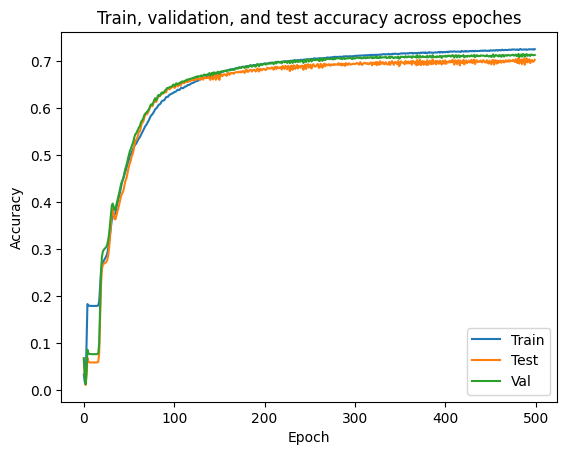

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(500)

plt.plot(x, train_accs, label = "Train")
plt.plot(x, test_accs, label = "Test")
plt.plot(x, valid_accs, label = "Val")

plt.title("Train, validation, and test accuracy across epoches")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can see the accuracy trends.

- Initial Learning Phase (Epochs 1-30): The model starts with low accuracy on all sets (training, validation, test).

- Significant Learning (Epochs 30-100): We found a noticeable improvement in accuracy across all datasets.

- Steady Improvement (Epochs 100-500): The model continues to improve gradually. The rate of improvement slows down as it converges towards its optimal performance given the architecture and data.

In [ ]:
x = np.arange(500)

plt.plot(x, losses)

plt.title("Train loss across epoches")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The best model yields an accuracy of 72.66% on the training set, 71.37% on the validation set, and 70.28% on the test set. This indicates good generalization as the validation and test accuracies are close to the training accuracy.

- **Overfitting**: The model does not appear to overfit significantly, as the training accuracy is not drastically higher than the validation and test accuracies.

- **Performance plateau**: Around epoch 300, the improvements in accuracy begin to plateau, suggesting that additional training beyond 500 epochs may not yield significant gains.

- **Limitations due to resources**: The reduced hidden dimension (64 instead of 128 as recommended in the original paper) due to resource limitations might have constrained the model's learning capacity.

### Training as directed graph

Now we perform the same training and testing pipeline on the same ogbn-arxiv dataset, but as a directed graph. Interestingly, we found a notable decrease in model performance compared to training on an undirected graph.

In [ ]:

dataset_name = 'ogbn-arxiv'
# We do not use sparse tensor for transformer model due to limitation on GPU resourses.
dataset = PygNodePropPredDataset(name=dataset_name)

print('The {} dataset has {} graph'.format(dataset_name, len(dataset)))
print("{} dataset has {} classes".format(dataset_name, dataset.num_classes))
print("{} dataset has {} features".format(dataset_name, dataset.num_features))

# Make sure that we are using cuda for fast training later.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

# Extract the graph
data = dataset[0]
data = data.to(device)
data.y = data.y.view(-1) # To avoid CUDA out of memory during evaluations.

split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

The ogbn-arxiv dataset has 1 graph

ogbn-arxiv dataset has 40 classes

ogbn-arxiv dataset has 128 features

Device: cuda


In [ ]:
model = UniMP(data.num_features, configs['hidden_dim'],
            dataset.num_classes, configs['num_layers'],
            configs['dropout'], heads=configs['num_heads']).to(device)

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=configs['lr'], weight_decay=configs['weight_decay'])
loss_fn = F.cross_entropy

best_model = None
best_valid_acc = 0

losses, train_accs, valid_accs, test_accs = [], [], [], []

epoch_str = 1
for epoch in range(epoch_str, epoch_str + configs["epochs"]):
  loss = train(model, data, train_idx, optimizer, loss_fn)
  result = test(model, data, split_idx)
  train_acc, valid_acc, test_acc = result
  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
  losses.append(loss)
  train_accs.append(train_acc)
  valid_accs.append(valid_acc)
  test_accs.append(test_acc)
  if epoch % 10 == 0:
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Epoch: 10, Loss: 3.8374, Train: 18.13%, Valid: 8.22% Test: 7.58%

Epoch: 20, Loss: 3.4776, Train: 18.67%, Valid: 9.59% Test: 7.71%

Epoch: 30, Loss: 3.1972, Train: 27.07%, Valid: 24.98% Test: 15.76%

Epoch: 40, Loss: 2.9254, Train: 31.75%, Valid: 31.57% Test: 25.97%

Epoch: 50, Loss: 2.6708, Train: 40.14%, Valid: 40.97% Test: 35.94%

Epoch: 60, Loss: 2.4434, Train: 44.58%, Valid: 45.84% Test: 41.25%

Epoch: 70, Loss: 2.2528, Train: 48.08%, Valid: 49.54% Test: 44.62%

Epoch: 80, Loss: 2.0998, Train: 50.79%, Valid: 52.32% Test: 47.52%

Epoch: 90, Loss: 1.9791, Train: 52.66%, Valid: 54.15% Test: 49.31%

Epoch: 100, Loss: 1.8880, Train: 54.61%, Valid: 55.31% Test: 50.43%

Epoch: 110, Loss: 1.8138, Train: 56.09%, Valid: 56.39% Test: 51.44%

Epoch: 120, Loss: 1.7540, Train: 57.13%, Valid: 56.95% Test: 51.81%

Epoch: 130, Loss: 1.7000, Train: 58.11%, Valid: 57.44% Test: 52.03%

Epoch: 140, Loss: 1.6637, Train: 58.85%, Valid: 58.00% Test: 52.49%

Epoch: 150, Loss: 1.6275, Train: 59.48%, Valid:

The final accuracies are 65.85% for the training set, 61.54% for the validation set, and 55. 36% for the test set. The test accuracy is notably lower than the training accuracy. These figures are lower compared to the performance on the undirected graph.

In [ ]:
best_result = test(model, data, split_idx)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Best model: Train: 65.85%, Valid: 61.54% Test: 55.36%


The accuracy plot shows a steady increase in all three datasets, while the loss plot indicates a consistent decrease.

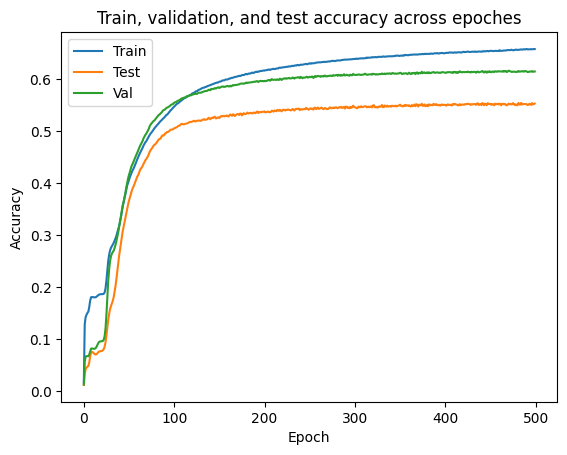

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(500)

plt.plot(x, train_accs, label = "Train")
plt.plot(x, test_accs, label = "Test")
plt.plot(x, valid_accs, label = "Val")

plt.title("Train, validation, and test accuracy across epoches")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

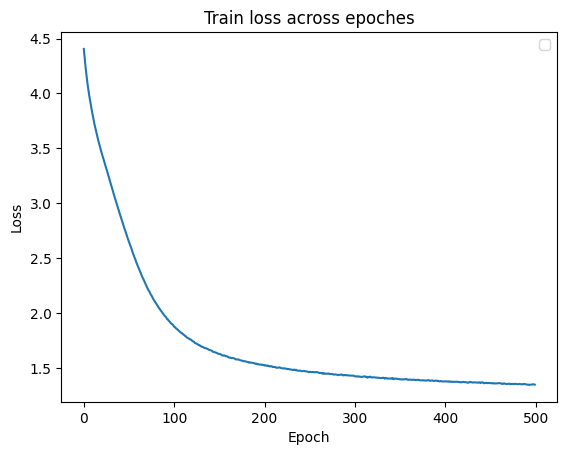

In [ ]:
x = np.arange(500)

plt.plot(x, losses)

plt.title("Train loss across epoches")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Analyze the results:


- **Overfitting**: A gap between training and test accuracies suggests mild overfitting. The model might be capturing some noise or specific patterns in the training data that do not generalize as well to unseen data.

- **Performance Plateau**: Similar to the undirected case, the model's improvements in accuracy begin to plateau around epoch 300, suggesting that extending training beyond 500 epochs might not lead to significant performance gains.


- The accuracies are lower **compared to** when the graph was treated as undirected. This could suggest that the undirected representation may capture more relevant information for this particular task, or that the model architecture and hyperparameters are more optimized for the undirected scenario. The decrease in performance when using a directed graph suggests that the model might rely on the symmetrical structure of undirected graphs. The UniMP model, being based on Transformer architecture, might be more suited to undirected graphs where each connection is equally informative in both directions.

